# 📊 Telecom X - Análise de Evasão de Clientes (Churn)
Este notebook contém todo o processo de carregamento, limpeza, engenharia de atributos  e análise exploratória de dados (EDA) para o projeto da Telecom X.

### 1. Importar Bibliotecas e Carregar Dados
Execute esta célula. Ela pedirá que você faça o upload do seu arquivo `.json` com os dados dos clientes.

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# Configuração visual dos gráficos
sns.set_theme(style='whitegrid')
cores_churn =['#1f77b4', '#ff7f0e']

# Fazer upload do arquivo JSON
print('Por favor, faça o upload do arquivo JSON com os dados (ex: telecom_data.json):')
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Carregar e achatar (flatten) o JSON
with open(filename, 'r', encoding='utf-8') as file:
    dados_json = json.load(file)

df = pd.json_normalize(dados_json)
print('\nDados carregados com sucesso. Tamanho original:', df.shape)
df.head(3)

Por favor, faça o upload do arquivo JSON com os dados (ex: telecom_data.json):


Saving TelecomX_Data.json to TelecomX_Data.json

Dados carregados com sucesso. Tamanho original: (7267, 21)


,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85


### 2. Tratamento e Limpeza de Dados

In [2]:
# 1. Renomear colunas (remover prefixos gerados pelo JSON)
df.columns = [col.split('.')[-1] for col in df.columns]

# 2. Tratar a variável alvo (Churn) - remover valores vazios
df['Churn'] = df['Churn'].replace('', np.nan)
df.dropna(subset=['Churn'], inplace=True)

# 3. Corrigir valores ocultos e o tipo de dado de 'Total' (Gastos Totais)
df['Total'] = df['Total'].replace(' ', '0')
df['Total'] = df['Total'].astype(float)

# 4. Padronizar variáveis categóricas (0/1 para No/Yes)
df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

cols_internet =['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for col in cols_internet:
    df[col] = df[col].replace('No internet service', 'No')

df['MultipleLines'] = df['MultipleLines'].replace('No phone service', 'No')

# 5. Remover duplicatas por ID do cliente
df.drop_duplicates(subset=['customerID'], inplace=True)

print('Limpeza concluída. Linhas restantes:', df.shape[0])

Limpeza concluída. Linhas restantes: 7043


### 3. Criação de Novas Variáveis
Vamos criar a coluna `Contas_Diarias` para entender o gasto diário do cliente.

In [3]:
df['Contas_Diarias'] = round(df['Monthly'] / 30, 2)
display(df[['customerID', 'Monthly', 'Contas_Diarias']].head())

,customerID,Monthly,Contas_Diarias
0,0002-ORFBO,65.6,2.19
1,0003-MKNFE,59.9,2.00
2,0004-TLHLJ,73.9,2.46
3,0011-IGKFF,98.0,3.27
4,0013-EXCHZ,83.9,2.80


### 4. Análise Exploratória de Dados (EDA)
#### 4.1 Análise Descritiva

In [4]:
cols_numericas =['tenure', 'Monthly', 'Total', 'Contas_Diarias']
display(df[cols_numericas].describe())

,tenure,Monthly,Total,Contas_Diarias
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304,2.158675
std,24.559481,30.090047,2266.794470,1.003088
min,0.000000,18.250000,0.000000,0.610000
25%,9.000000,35.500000,398.550000,1.180000
50%,29.000000,70.350000,1394.550000,2.340000
75%,55.000000,89.850000,3786.600000,2.990000
max,72.000000,118.750000,8684.800000,3.960000


#### 4.2 Distribuição da variável alvo (Churn)

/tmp/ipython-input-1179/3383744820.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='Churn', palette=cores_churn)


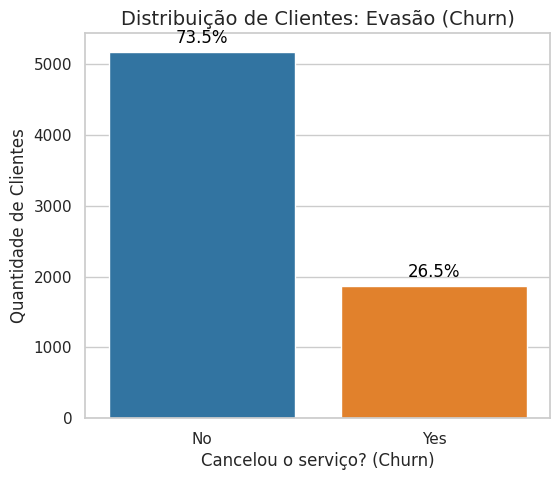

In [5]:
plt.figure(figsize=(6, 5))
ax = sns.countplot(data=df, x='Churn', palette=cores_churn)
plt.title('Distribuição de Clientes: Evasão (Churn)', fontsize=14)
plt.xlabel('Cancelou o serviço? (Churn)', fontsize=12)
plt.ylabel('Quantidade de Clientes', fontsize=12)

# Porcentagens nas barras
total = len(df)
for p in ax.patches:
    percentual = f'{100 * p.get_height() / total:.1f}%'
    ax.annotate(percentual, (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                textcoords='offset points')
plt.show()

#### 4.3 Evasão por Variáveis Categóricas (Perfil do Cliente)

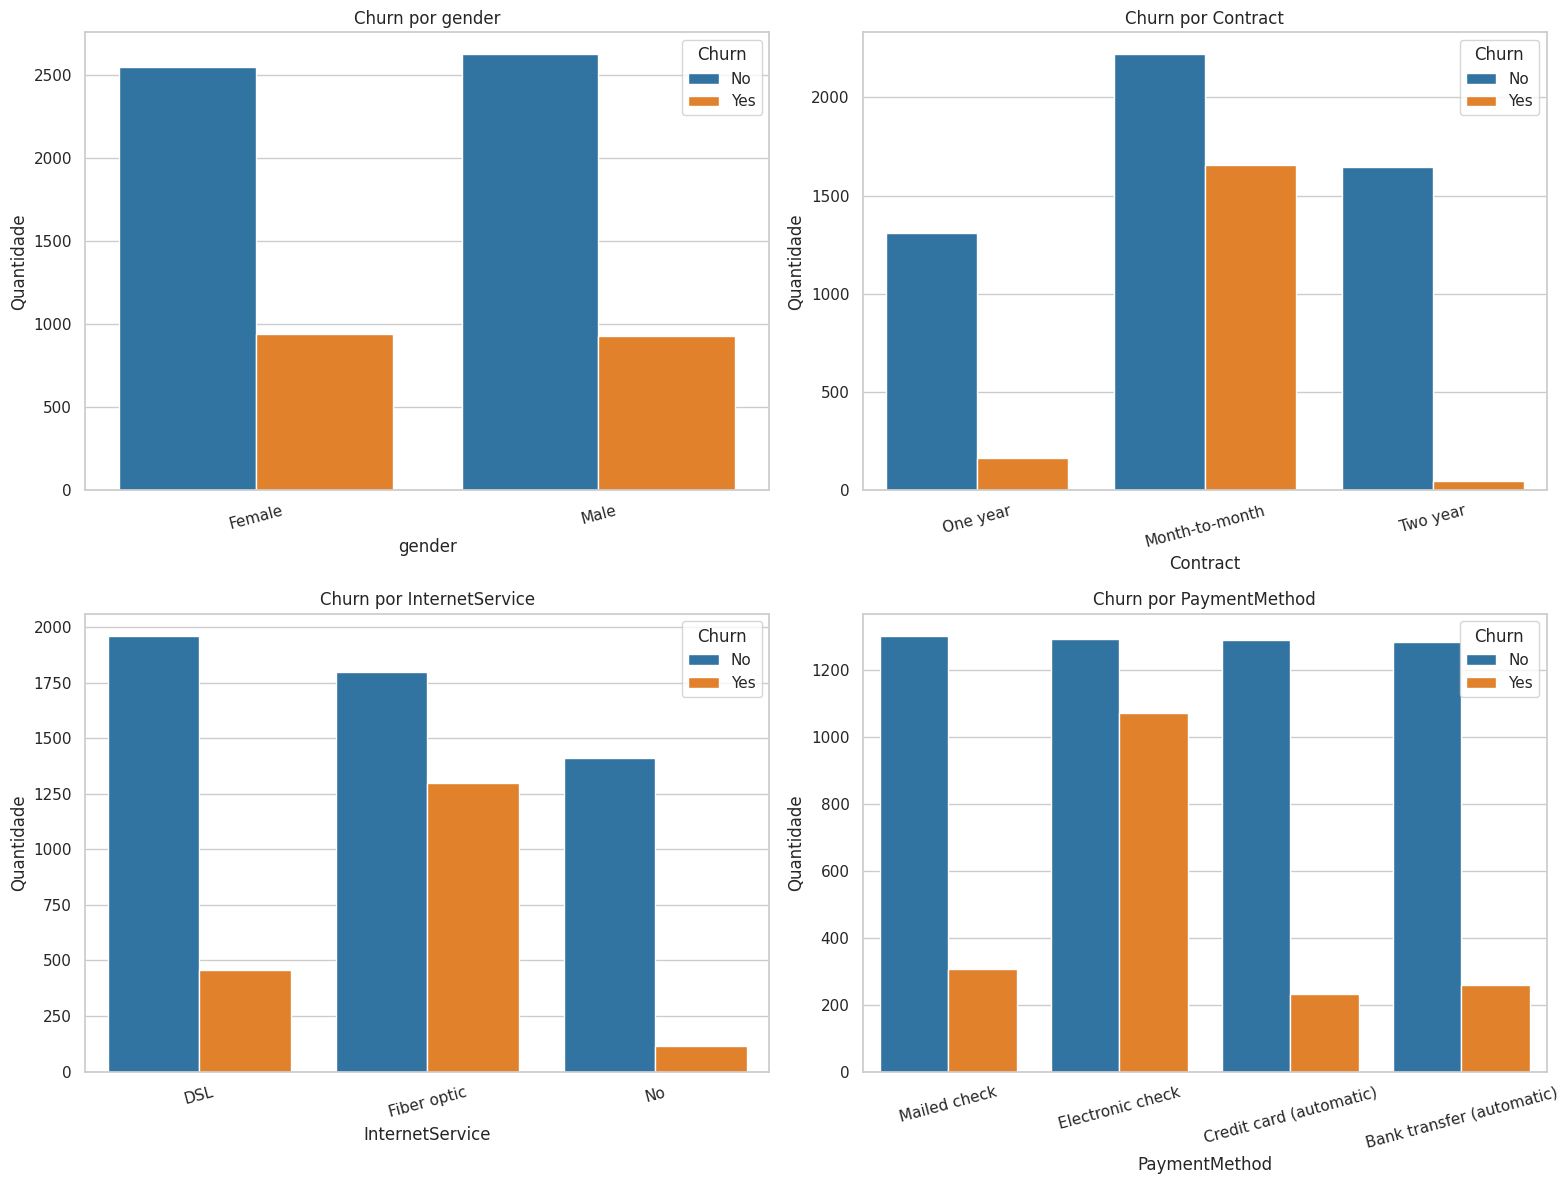

In [6]:
vars_categoricas =['gender', 'Contract', 'InternetService', 'PaymentMethod']

plt.figure(figsize=(16, 12))
for i, var in enumerate(vars_categoricas, 1):
    plt.subplot(2, 2, i)
    sns.countplot(data=df, x=var, hue='Churn', palette=cores_churn)
    plt.title(f'Churn por {var}', fontsize=12)
    plt.xlabel(var)
    plt.ylabel('Quantidade')
    plt.xticks(rotation=15)

plt.tight_layout()
plt.show()

#### 4.4 Evasão por Variáveis Numéricas (Boxplots)

/tmp/ipython-input-1179/3786218383.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Churn', y='tenure', palette=cores_churn)
/tmp/ipython-input-1179/3786218383.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Churn', y='Monthly', palette=cores_churn)
/tmp/ipython-input-1179/3786218383.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Churn', y='Contas_Diarias', palette=cores_churn)


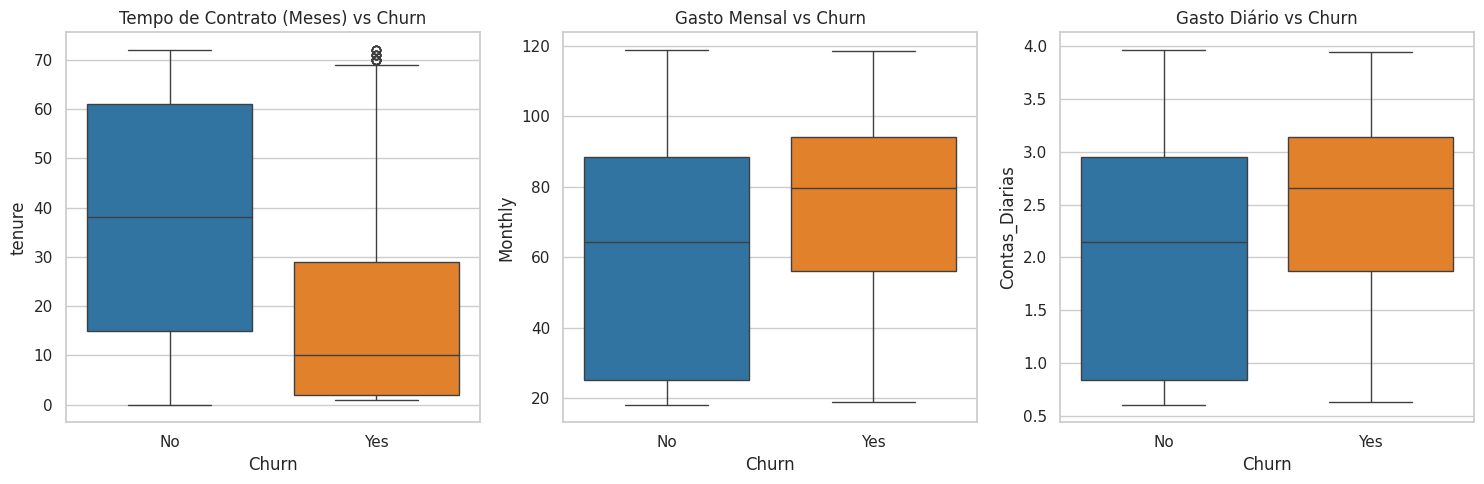

In [7]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(data=df, x='Churn', y='tenure', palette=cores_churn)
plt.title('Tempo de Contrato (Meses) vs Churn')

plt.subplot(1, 3, 2)
sns.boxplot(data=df, x='Churn', y='Monthly', palette=cores_churn)
plt.title('Gasto Mensal vs Churn')

plt.subplot(1, 3, 3)
sns.boxplot(data=df, x='Churn', y='Contas_Diarias', palette=cores_churn)
plt.title('Gasto Diário vs Churn')

plt.tight_layout()
plt.show()

# **RELATÓRIO EXECUTIVO: Análise de Evasão de Clientes (Churn)**

# **1. Introdução**

O presente relatório tem como objetivo apresentar os resultados da análise preliminar de dados referentes à base de clientes da Telecom X. Atualmente, a empresa enfrenta um desafio estratégico relacionado à alta taxa de cancelamento de serviços, métrica conhecida no mercado como Churn.

A evasão de clientes afeta diretamente a receita e o custo de aquisição da empresa. Portanto, o objetivo desta análise foi extrair, limpar e investigar os dados brutos da API da Telecom X para identificar padrões demográficos, contratuais e financeiros que expliquem por que os clientes estão deixando a empresa. Os insights aqui gerados servirão de base para a criação de modelos preditivos e ações de retenção.

# **2. Limpeza e Tratamento de Dados**

Os dados originais foram extraídos em formato JSON. Como possuíam uma estrutura aninhada (dicionários dentro de dicionários), foi necessário aplicar técnicas de manipulação de dados utilizando a biblioteca Pandas em Python.
Os seguintes passos foram executados para garantir a qualidade e a confiabilidade dos dados:

Achatamento (Flattening): Conversão da estrutura JSON para um
formato tabular (DataFrame).

Renomeação de Colunas: Remoção de prefixos técnicos para adequação ao Dicionário de Dados do negócio.

Tratamento da Variável Alvo (Churn): Identificação e remoção de registros onde o status de cancelamento estava em branco, garantindo a fidelidade da análise.

Correção de Tipagem de Dados: A coluna de Gasto Total (Total) foi convertida de texto para numérico. Valores preenchidos apenas com espaços em branco (clientes novos, sem fatura gerada) foram substituídos por zero.

Padronização Categórica: Variáveis booleanas (como SeniorCitizen) foram convertidas de 0/1 para 'No/Yes', mantendo a consistência com o restante do banco de dados.

Engenharia de Atributos (Feature Engineering): Criação da variável Contas_Diarias (Gasto Mensal / 30), permitindo avaliar a sensibilidade do cliente ao preço diário do serviço.

Remoção de Duplicatas: Garantia de que cada customerID fosse único no conjunto de dados.


# **3. Análise Exploratória de Dados (EDA)**
A análise exploratória buscou entender a distribuição do Churn e sua relação com outras variáveis do negócio.
3.1. Visão Geral da Evasão

Ao analisar a variável alvo de forma isolada, identificamos a taxa base de cancelamento da Telecom X.



Observação: O gráfico revela a proporção exata de clientes retidos versus clientes perdidos, destacando o tamanho do desafio e evidenciando um desbalanceamento natural nos dados (há mais clientes ativos do que cancelados).

/tmp/ipython-input-1179/3383744820.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='Churn', palette=cores_churn)


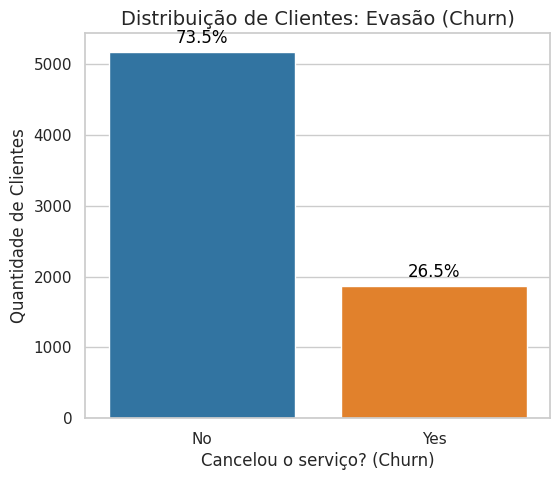

In [8]:
plt.figure(figsize=(6, 5))
ax = sns.countplot(data=df, x='Churn', palette=cores_churn)
plt.title('Distribuição de Clientes: Evasão (Churn)', fontsize=14)
plt.xlabel('Cancelou o serviço? (Churn)', fontsize=12)
plt.ylabel('Quantidade de Clientes', fontsize=12)

# Porcentagens nas barras
total = len(df)
for p in ax.patches:
    percentual = f'{100 * p.get_height() / total:.1f}%'
    ax.annotate(percentual, (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                textcoords='offset points')
plt.show()

## **3.2. Evasão por Perfil e Contrato (Variáveis Categóricas)**
Avaliamos como as características do serviço e o perfil do cliente afetam o cancelamento.

Padrões Identificados:
Contrato: Clientes com contratos de renovação mensal (Month-to-month) representam a esmagadora maioria dos cancelamentos. Contratos anuais ou bienais possuem taxas de retenção excelentes.
Serviço de Internet: Clientes que utilizam Fibra Ótica (Fiber optic) cancelam em proporção muito maior do que usuários de internet via cabo (DSL).
Método de Pagamento: Usuários que pagam via Boleto Eletrônico (Electronic check) possuem uma taxa de evasão criticamente superior às demais formas de pagamento automático.
Gênero: Não há diferença significativa de cancelamento entre homens e mulheres.

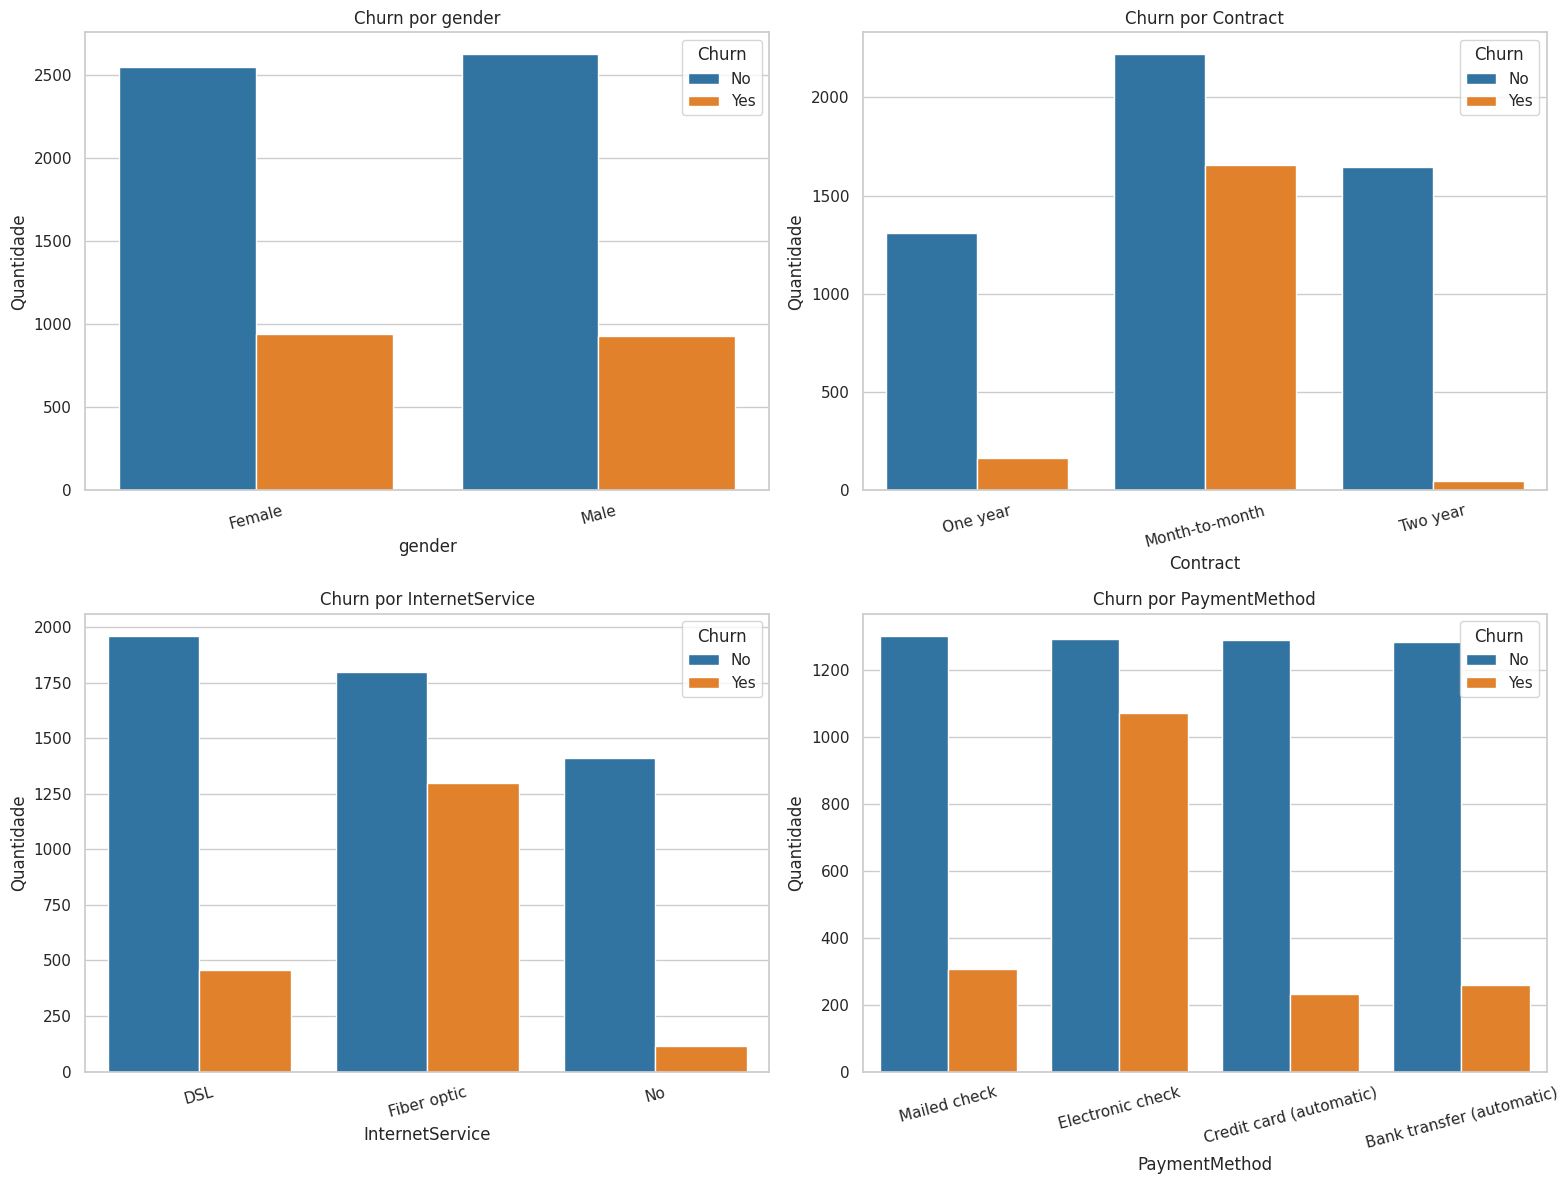

In [9]:
vars_categoricas =['gender', 'Contract', 'InternetService', 'PaymentMethod']

plt.figure(figsize=(16, 12))
for i, var in enumerate(vars_categoricas, 1):
    plt.subplot(2, 2, i)
    sns.countplot(data=df, x=var, hue='Churn', palette=cores_churn)
    plt.title(f'Churn por {var}', fontsize=12)
    plt.xlabel(var)
    plt.ylabel('Quantidade')
    plt.xticks(rotation=15)

plt.tight_layout()
plt.show()

**3.3. Comportamento Financeiro e Tempo de Casa (Variáveis Numéricas)**

Utilizamos gráficos de dispersão (Boxplots) para entender o impacto do tempo de contrato e do valor da fatura.



Padrões Identificados:
Tempo de Contrato (tenure): A evasão está concentrada nos primeiros meses de vida do cliente. Clientes que passam da barreira de 1 a 2 anos tendem a se fidelizar.
Gasto Mensal e Diário: Os clientes que cancelam tendem a ter faturas mensais (e contas diárias) visivelmente mais altas. Existe uma clara sensibilidade ao preço.

/tmp/ipython-input-1179/3786218383.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Churn', y='tenure', palette=cores_churn)
/tmp/ipython-input-1179/3786218383.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Churn', y='Monthly', palette=cores_churn)
/tmp/ipython-input-1179/3786218383.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Churn', y='Contas_Diarias', palette=cores_churn)


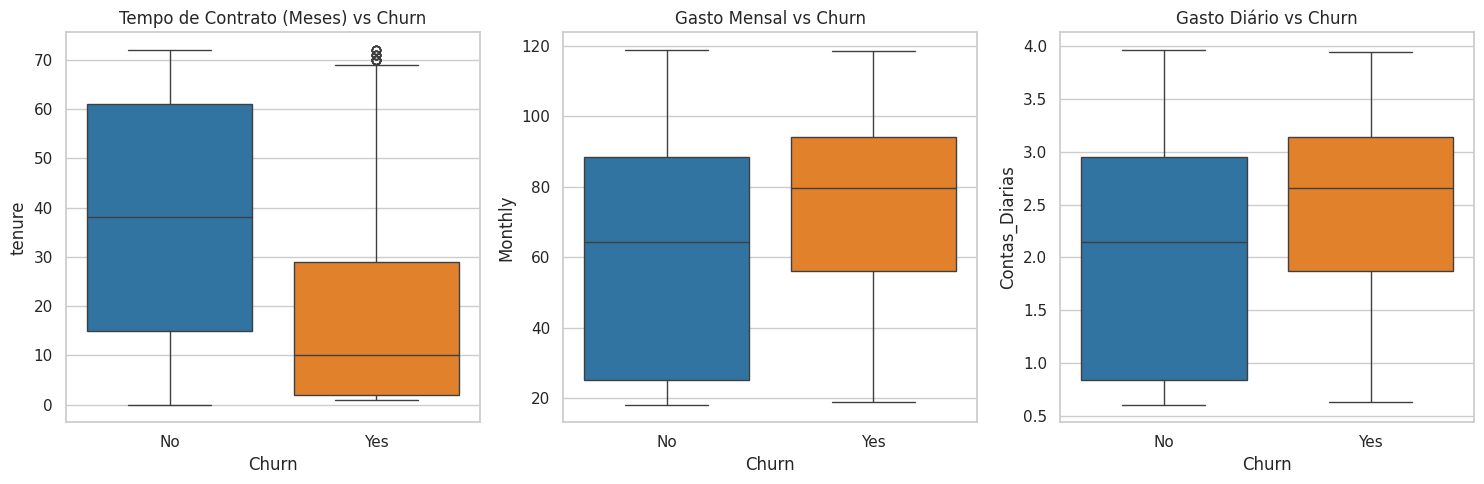

In [10]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(data=df, x='Churn', y='tenure', palette=cores_churn)
plt.title('Tempo de Contrato (Meses) vs Churn')

plt.subplot(1, 3, 2)
sns.boxplot(data=df, x='Churn', y='Monthly', palette=cores_churn)
plt.title('Gasto Mensal vs Churn')

plt.subplot(1, 3, 3)
sns.boxplot(data=df, x='Churn', y='Contas_Diarias', palette=cores_churn)
plt.title('Gasto Diário vs Churn')

plt.tight_layout()
plt.show()

# **4. Conclusões e Insights**
A partir da análise dos dados da Telecom X, concluímos que a evasão não ocorre de forma aleatória. Ela está fortemente ligada a fatores contratuais, atrito financeiro e percepção de valor.

Os principais insights são:

Falta de Vínculo: A empresa perde a maioria dos seus clientes nos primeiros meses, indicando um possível problema de alinhamento de expectativas no momento da venda ou deficiência no onboarding (processo de entrada do cliente).

A armadilha da Fibra Ótica: Sendo o serviço mais caro, a Fibra Ótica atrai contas mensais/diárias mais altas, o que afeta a percepção de custo-benefício do cliente, resultando em cancelamento rápido se o serviço não for perfeito.

Atrito no Pagamento: O pagamento manual (Electronic check) facilita a decisão impulsiva de não pagar e cancelar o serviço, diferente do débito automático que retém o cliente por comodidade.

# **5. Recomendações**
Com base nas conclusões acima, sugiro as seguintes ações estratégicas para a redução do Churn na Telecom X:
Incentivo a Contratos Longos: Criar campanhas de upsell oferecendo descontos significativos nas primeiras faturas para clientes que aceitarem migrar do contrato mensal para o contrato de 1 ano.

Programa de Onboarding: Implementar um acompanhamento mais próximo (Customer Success) nos primeiros 3 a 6 meses do cliente, garantindo que ele veja o valor do serviço contratado antes de considerar o cancelamento.

Revisão Técnica e Comercial da Fibra Ótica: Investigar junto à equipe de infraestrutura se há instabilidade no serviço de fibra óptica ou realizar pesquisas de satisfação para entender se o preço cobrado está sendo percebido como abusivo frente aos concorrentes.

Estímulo ao Débito Automático: Oferecer isenção de taxas ou bônus de dados para clientes que cadastrarem o cartão de crédito ou débito automático em conta, reduzindo o atrito gerado pelo "Electronic check".

Avanço Analítico: Disponibilizar este conjunto de dados tratado para os Cientistas de Dados Sêniores desenvolverem um modelo preditivo de Machine Learning, capaz de sinalizar automaticamente quais clientes atuais têm risco de evasão no próximo mês, permitindo ação preventiva.